This example contains a code sample of Shor's algorithm for factorization. In this example, we will be attempting to factor the number $N = 15$. This example will only cover the section of the computation related to quantum circuits, not the sections done on classical computers.

In [1]:
using SymbolicQuantumSimulator
using StatsPlots
using SymPy

┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API ~/.julia/juliaup/julia-1.10.7+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/API.jl:1848
Precompiling SymbolicQuantumSimulator
  ✓ SymbolicQuantumSimulator
  1 dependency successfully precompiled in 5 seconds. 26 already precompiled.
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API ~/.julia/juliaup/julia-1.10.7+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/API.jl:1848
[ Info: Precompiling StatsPlotsExt [c98267f3-c073-5a6e-bd72-cc0fa896355a]


In [2]:
Base.retry_load_extensions()

Shor's algorithm uses the algorithm for Quantum phase estimation (QPE) to find the order of an operator $U_k(a) $, which multiplies a number $a$ by a factor of $k$ modulo $N$. To implement QPE for this operator, we need to be able to express it in terms of quantum gates. We also set up a circuit for computing the inverse quantum Fourier transform (IQFT).

In [3]:
function circuit_x_7_mod_15(power::Int)
    qreg = QuantumRegister(4, "q")
    qc = QuantumCircuit(qreg...)
    
    for iteration = 1:power
        push!(qc, SwapGate(qreg[3], qreg[4]))
        push!(qc, SwapGate(qreg[2], qreg[3]))
        push!(qc, SwapGate(qreg[1], qreg[2]))

        append!(qc, XGate.(qreg))
    end
    
    return qc
end

function iqft(n::Integer)
    qreg = QuantumRegister(n, "q")
    qc = QuantumCircuit(qreg...)
    
    for i = n ÷ 2:-1:1
        push!(qc, SwapGate(qreg[i], qreg[n + 1 - i]))
    end
    
    for control = 1:n
        push!(qc, HGate(qreg[control]))
    
        k = 2
            for target = control+1:n
            push!(qc, CPGate(-Sym(2) / Sym(2) ^ k * PI, qreg[control], qreg[target]))
            k += 1
        end
    end
    
    return qc
end

iqft (generic function with 1 method)

The operator $U_k(a)$ looks as follows:

In [4]:
draw(circuit_x_7_mod_15(1))

              ┌───┐
q_1: ───────X─┤ X ├
            │ ├───┤
q_2: ────X──X─┤ X ├
         │    ├───┤
q_3: ─X──X────┤ X ├
      │       ├───┤
q_4: ─X───────┤ X ├
              └───┘


We can obtain its integer powers by simply chaining the gates that the operator is comprised of:

In [5]:
draw(circuit_x_7_mod_15(2))

              ┌───┐         ┌───┐
q_1: ───────X─┤ X ├───────X─┤ X ├
            │ ├───┤       │ ├───┤
q_2: ────X──X─┤ X ├────X──X─┤ X ├
         │    ├───┤    │    ├───┤
q_3: ─X──X────┤ X ├─X──X────┤ X ├
      │       ├───┤ │       ├───┤
q_4: ─X───────┤ X ├─X───────┤ X ├
              └───┘         └───┘


Now, we can construct, visualize and run the complete circuit:

In [6]:
t = 8
n = 4

qfirst = QuantumRegister(t, "qfirst")
qsecond = QuantumRegister(n, "qsecond")

4-element Vector{Qubit}:
 Qubit("qsecond_1")
 Qubit("qsecond_2")
 Qubit("qsecond_3")
 Qubit("qsecond_4")

In [7]:
qc = QuantumCircuit(qfirst..., qsecond...)

push!(qc, XGate(qsecond[1]))
push!(qc, Barrier())

append!(qc, HGate.(qfirst))
push!(qc, Barrier())

for control = t:-1:1
    exponent = 2 ^ (control - 1)
    mult_gate = circuit_to_gate(circuit_x_7_mod_15(exponent), qsecond...; name="7^" * string(exponent))
    push!(qc, controlled(mult_gate, qfirst[control]))
end

push!(qc, circuit_to_gate(iqft(length(qfirst)), qfirst...; name="IQFT"))

append!(qc, Measurement.(qfirst))

In [8]:
draw(qc)

                   ┌───┐                                                                        »
 qfirst_1: ──────░─┤ H ├─░──────────────────────────────────────────────────────────────────■───»
                 ░ ├───┤ ░                                                                  │   »
 qfirst_2: ──────░─┤ H ├─░──────────────────────────────────────────────────────────■───────┼───»
                 ░ ├───┤ ░                                                          │       │   »
 qfirst_3: ──────░─┤ H ├─░──────────────────────────────────────────────────■───────┼───────┼───»
                 ░ ├───┤ ░                                                  │       │       │   »
 qfirst_4: ──────░─┤ H ├─░──────────────────────────────────────────■───────┼───────┼───────┼───»
                 ░ ├───┤ ░                                          │       │       │       │   »
 qfirst_5: ──────░─┤ H ├─░─────────────────────────────────■────────┼───────┼───────┼───────┼───»
                 ░ ├

In [9]:
results = simulate_measurements(qc; leave_out_zeros = true)

Dict{String, Sym} with 4 entries:
  "00000011" => 1/4
  "00000001" => 1/4
  "00000000" => 1/4
  "00000010" => 1/4

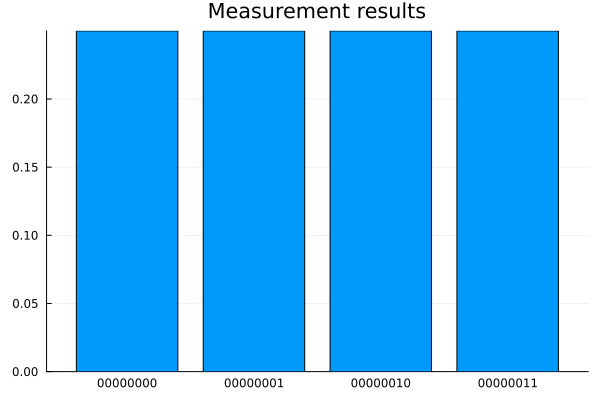

In [10]:
plot_measurements(results)

The rest of the computation is described e.g. in this [article on Medium](https://medium.com/mit-6-s089-intro-to-quantum-computing/a-general-implementation-of-shors-algorithm-da1595694430).